# Classificação de Tipos de Sacolas para Reciclagem

---

- Dataset: Plastic Paper Garbage Bag Synthetic Images
- Disponível em: https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images


Este dataset contém imagens sintéticas de sacos de lixo, plástico e de papel, úteis para tarefas de classificação e segmentação de imagens no contexto de reconhecimento de objetos e reciclagem automática.

---

**Créditos:**
O dataset foi criado e disponibilizado por vencerlanz09 na plataforma Kaggle. Seu uso está sujeito às regras da plataforma e às licenças associadas. Sempre consulte os termos oficiais no link do dataset para uso comercial ou redistribuição.

## Imports e Carregando o Dataset

In [ ]:
!pip install -q kaggle

In [ ]:
# Manipulação de arquivos

import pathlib
import zipfile
from google.colab import files

# Imagens
from PIL import Image

# Números e Visualização

import matplotlib.pyplot as plt
import numpy as np

# TensorFlow e callbacks

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
files.upload()  # Vai abrir uma caixa para upload do seu kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"patrickregis","key":"103d38076a1d4bb72439b211012992e0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images
License(s): CC-BY-SA-4.0
 89% 403M/451M [00:00<00:00, 456MB/s]
100% 451M/451M [00:00<00:00, 493MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("plastic-paper-garbage-bag-synthetic-images.zip", "r") as zip_ref:
    zip_ref.extractall("dados")

## Acessando o Diretório e Explorando o Dataset

In [ ]:
dir = pathlib.Path('dados/Bag Classes/Bag Classes')
len(list(dir.glob('*/*.jpg')))

15000

In [ ]:
# Nomes das subpastas

subfolders = [f.name for f in dir.iterdir() if f.is_dir()]
subfolders

['Paper Bag Images', 'Plastic Bag Images', 'Garbage Bag Images']

In [ ]:
paper_bags = list(dir.glob('Paper Bag Images/*.jpg'))
plastic_bags = list(dir.glob('Plastic Bag Images/*.jpg'))
garbage_bags = list(dir.glob('Garbage Bag Images/*.jpg'))

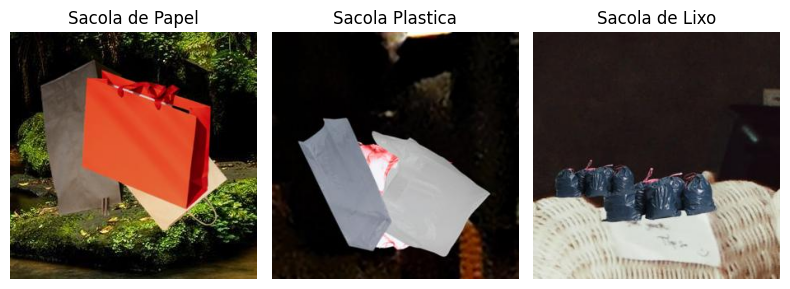

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
ax[0].imshow(PIL.Image.open(paper_bags[0]))
ax[0].set_title('Sacola de Papel')
ax[0].axis('off')

ax[1].imshow(PIL.Image.open(plastic_bags[0]))
ax[1].set_title('Sacola Plastica')
ax[1].axis('off')

ax[2].imshow(PIL.Image.open(garbage_bags[0]))
ax[2].set_title('Sacola de Lixo')
ax[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Num. Imagens p/ pasta

for subfolder in subfolders:
  path = dir/subfolder
  images = list(path.glob('*.jpg'))
  print(f'Classe {subfolder}: {len(images)} imagens')

# Dimensões

  if images:
    img = PIL.Image.open(str(images[0]))
    img_array = np.array(img)
    print(f"Dimensões imagem nº 1, classe '{subfolder}': {img_array.shape}\n")

Classe Paper Bag Images: 5000 imagens
Dimensões imagem nº 1, classe 'Paper Bag Images': (300, 300, 3)

Classe Plastic Bag Images: 5000 imagens
Dimensões imagem nº 1, classe 'Plastic Bag Images': (300, 300, 3)

Classe Garbage Bag Images: 5000 imagens
Dimensões imagem nº 1, classe 'Garbage Bag Images': (300, 300, 3)



# Treino e Validação

In [ ]:
# Tamanho de entrada. Dimensões = 300 x 300 x 3 (canais de cores)

input_shape = (300, 300, 3)

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset='training',
    seed=12,
    image_size=(300,300),
    batch_size = 64
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.


In [ ]:
validation = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset='validation',
    seed=12,
    image_size=(300,300),
    batch_size = 64
)


Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


In [ ]:
# Checando GPU para treino

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Rescaling, Graf. Desempenho e Callbacks

In [ ]:
# Rescaling

rescale = tf.keras.layers.Rescaling(1./255)
train = train.map(lambda x, y: (rescale(x), y))
validation = validation.map(lambda x, y: (rescale(x), y))

In [ ]:
# Gráfico Desempenho

def plot_results(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']


  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc)
  plt.plot(val_acc)

  plt.title('Acurácia do Treino x Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.legend(['Treino', 'Validação'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(loss)
  plt.plot(val_loss)

  plt.title('Perda do Treino x Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Perda')
  plt.legend(['Treino', 'Validação'], loc='upper right')


In [ ]:
# Early Stopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,                     # Aguarda 3 épocas sem melhora
    restore_best_weights=True,
    verbose=1
)

# **InceptionV3** - Transfer Learning

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape = input_shape,
                                                include_top=False,
                                                weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
# Sumário do InceptionV3
# base_model.summary()

In [ ]:
ll = base_model.get_layer('mixed8').output # ll = last layer

# Modelo Completo

In [ ]:
x = tf.keras.layers.Flatten()(ll)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = base_model.input, outputs=x)

# model.summary()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Realizando o treinamento

epochs = 20
history = model.fit(train,
                    epochs = epochs,
                    callbacks = [early_stop],
                    validation_data = validation)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 401ms/step - accuracy: 0.7764 - loss: 6.6476 - val_accuracy: 0.9753 - val_loss: 0.0670
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 252ms/step - accuracy: 0.9863 - loss: 0.0355 - val_accuracy: 0.9740 - val_loss: 0.0744
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 258ms/step - accuracy: 0.9969 - loss: 0.0111 - val_accuracy: 0.9780 - val_loss: 0.0584
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 249ms/step - accuracy: 0.9981 - loss: 0.0064 - val_accuracy: 0.9793 - val_loss: 0.0593
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.9590 - val_loss: 0.1242
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 256ms/step - accuracy: 0.9872 - loss: 0.0383 - val_accuracy: 0.9820 - val_loss: 0.0513
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 246ms/step - accuracy: 0.9981 - loss: 0.0055 - val_accuracy: 0.9830 - val_loss: 0.0646
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.9929 - loss: 0

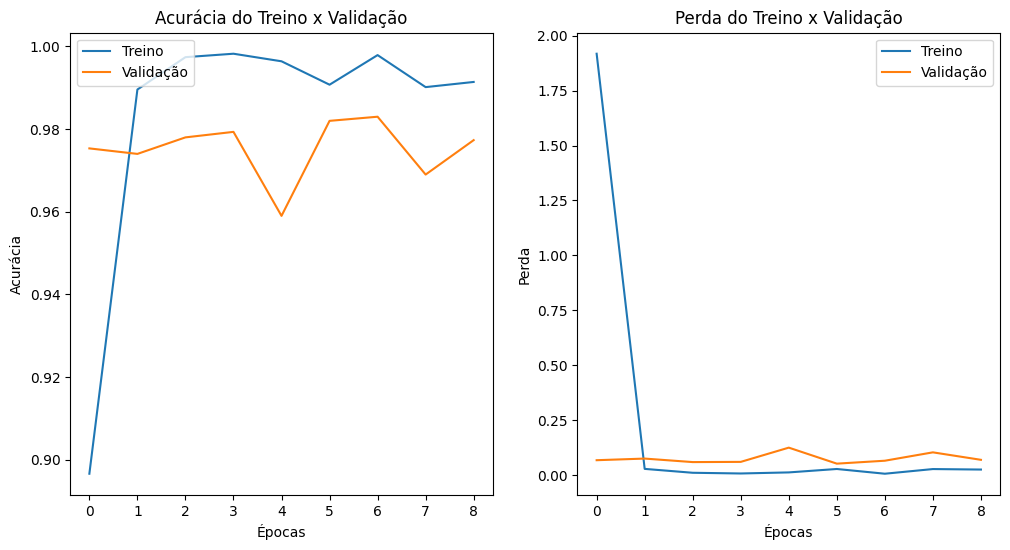

In [ ]:
plot_results(history)

# Salvando Modelo

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

model_tflite_quant = converter.convert()

with open('bag_class_optimized.tflite', 'wb') as f:
    f.write(model_tflite_quant)

Saved artifact at '/tmp/tmpb34yr6mm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='keras_tensor_630')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137891542826256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137891542823760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137891542826832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137891542826448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137890173976848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137890173977808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137890173978192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137890173978384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137890173979344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137890173977424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378901739